In [87]:
import argparse
from math import log10
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.functional as f
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.cuda as cuda

import time
import numpy as np
import os
from RANet_lib import *
from RANet_lib.RANet_lib import *
from RANet_model import RANet as Net
import os
import os.path as osp
from glob import glob

import matplotlib.pyplot as plt
from torchvision import transforms
import PIL.Image as Image
import PIL

In [2]:
from vj_davis_17_loader import Custom_DAVIS2017_dataset
from torch.utils.data import DataLoader

In [3]:
net_name = 'RANet'
parser = argparse.ArgumentParser(description='RANet')
parser.add_argument('--deviceID', default=[0], help='device IDs')
parser.add_argument('--threads', type=int, default=16, help='number of threads for data loader to use')
parser.add_argument('--workfolder', default='../models/')
parser.add_argument('--savePName', default=net_name)
parser.add_argument('--net_type', default='single_object')
parser.add_argument('--fp16', default=True)
print('===> Setting ......')
# opt = parser.parse_args()
class args:
    pass
opt = args()
opt.deviceID = [0]
opt.threads=0
opt.workfolder='../models/'
opt.savePName = net_name
opt.net_type='single_object'
opt.fp16=False

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

try:
    os.mkdir(opt.workfolder)
    print('build working folder: ' + opt.workfolder)
except:
    print(opt.workfolder + 'exists')
print('using device ID: {}'.format(opt.deviceID))


print('===> Building model')
params='RANet_video_multi.pth'
params='RANet_encoder_retrain_epoch1.pth'
dataset='17train'
save_root='../predictions/RANet_Video_17val'

model = Net(pretrained=False, type=opt.net_type)
model_cuda = None
inSize1 = 480
inSize2 = 864
if dataset in ['16val', '16trainval', '16all']:
    model.set_type('single_object')
    year = '2016'
elif dataset in ['17val', '17test_dev', '17train']:
    model.set_type('multi_object')
    year = '2017'
else:
    assert('dataset error')
checkpoint_load(opt.workfolder + params, model)

if opt.deviceID==[0]:
    model_cuda = model.cuda()
else:
    model_cuda = nn.DataParallel(model).cuda()
if opt.fp16:
    model_cuda = model_cuda.half()
    model_cuda.fp16 = True

root = '../datasets/DAVIS'
img_mode = '480p'
img_shape = (inSize1,inSize2)

===> Setting ......
../models/exists
using device ID: [0]
===> Building model
Single-object mode
Change to multi-object mode
=> Loaded checkpoint '../models/RANet_encoder_retrain_epoch1.pth'


In [273]:
class RandomCrop(object):
    """
    This function crops randomly in the image/mask pairs in the sample
    The random cropping is constant for all image/mask pairs in the sample
    But all images should be of same size
    Args:
        min_size: Minimum size of crop, as ratio to actual image size
        prob: probability of applying crop on a sample list
    """

    def __init__(self,min_size:float=0.75, prob:float=0):
        self.min_size = min_size
        self.prob=prob

    def __call__(self, sample):
        if (np.random.random_sample()>self.prob):
            return sample
        return_sample = []
        
        g_w_low= sample[0].size[0]
        g_h_low = sample[0].size[1]
        g_w_high = 0
        g_h_high = 0
        
        for i in range(len(sample)//2):
            img = sample[2*i]
            msk = sample[2*i + 1]
            
            w, h = msk.size[:2]
            min_h  = int(h*self.min_size)
            min_w = int(w*self.min_size)
            
            h_low, w_low = np.min(np.asarray(msk).nonzero(),axis=1) ## numpy array gives in height , width config
            h_high, w_high = np.max(np.asarray(msk).nonzero(),axis=1)
            
            if (h_high - h_low) < min_h:
                if (h_low <= min_h//2):
                    h_low = 0
                else:
                    h_low = h_low - min_h//2    
                h_high = h_low + min_h
            
            if (w_high - w_low) < min_w:
                if (w_low <= min_w//2):
                    w_low = 0
                else:
                    w_low = w_low - min_w//2    
                w_high = w_low + min_w
            
            #### Pick the min crop size as one which satisfies all image masks in the sample
            g_w_low= min(w_low, g_w_low)
            g_h_low = min(h_low, g_h_low)
            g_w_high = max(w_high, g_w_high)
            g_h_high = max(h_high, g_h_high)
            
        left = np.random.randint(0, w_low+1)
        right = np.random.randint(w_high, w)

        top = np.random.randint(0, h_low+1)
        bottom = np.random.randint(h_high, h)
        print("crop tuple:",(left, top, right, bottom))

        for i in range(len(sample)//2):
            img = sample[2*i]
            msk = sample[2*i + 1]
            
            img = img.crop((left, top, right, bottom)).resize((w,h),resample=Image.BILINEAR)
            msk = msk.crop((left, top, right, bottom)).resize((w,h),resample=Image.NEAREST)
            return_sample.append(img)
            return_sample.append(msk)

        return return_sample

class RandomRotate(object):
    """
    This function rotates randomly in the image/mask pairs in the sample
    The random rotation is constant for all image/mask pairs in the sample
    Args:
        max_angle: max angle to rotate, in radians
        prob: probability of applying crop on a sample list
    """

    def __init__(self,max_angle:float=np.pi/8, prob:float=0):
        self.max_angle = max_angle*(180/np.pi)
        self.prob=prob
        
        self.fn = transforms.functional.rotate
        
    def __call__(self, sample):
        if (np.random.random_sample()>self.prob):
            return sample
        return_sample = []
        angle = self.max_angle*(np.random.random_sample()-0.5)*2
        print("rotate by angle:", angle)
        for i in range(len(sample)//2):
            img = sample[2*i]
            msk = sample[2*i + 1]
            
            return_sample.append(self.fn(img, angle=angle, resample=Image.BILINEAR))
            return_sample.append(self.fn(msk, angle=angle, resample=Image.BILINEAR))
        return return_sample



class RandomFlip(object):
    """
    This function Flips image/mask pairs in the sample
    The decision to flip and the direction is constant for all image/mask pairs in the sample
    Args:
        vprob: max angle to flip vertically
        hprob: probability to flip horizontally
    """

    def __init__(self,vprob:float=0, hprob:float=0):
        self.vprob = vprob
        self.hprob=hprob
        
        self.hflip = transforms.functional.hflip
        self.vflip = transforms.functional.vflip
        
    def __call__(self, sample):
        return_sample = []
        if (np.random.random_sample()<self.hprob):
            print("hflip")
            for i in range(len(sample)):
                return_sample.append(self.hflip(sample[i]))
            sample = return_sample
    
        return_sample = []
        if (np.random.random_sample()<self.vprob):
            print("vflip")
            for i in range(len(sample)):
                return_sample.append(self.vflip(sample[i]))
            sample = return_sample
        return sample

In [274]:
trnsfm_crop = RandomCrop(min_size=0.75, prob=0.2)
trnsfm_rotate=RandomRotate(max_angle=np.pi/8, prob=0.2)
trnsfm_flip=RandomFlip(vprob=0.1, hprob=0.5)

trnsfm = transforms.Compose([trnsfm_crop,trnsfm_rotate,trnsfm_flip])

In [282]:


name = img_dataset.names[2]

# Got which video to pick. Now pick two images from the list
img_counter = int(img_dataset.img_counter[name])

base_frame = Image.open(img_dataset.video_files[name][img_counter-1][0])
base_mask = Image.open(img_dataset.video_files[name][img_counter-1][1])
objs_ids = list(set(np.asarray(base_mask).reshape(-1)))

name2 = img_dataset.names[45]
img_counter2 = int(img_dataset.img_counter[name2])

base_frame2 = Image.open(img_dataset.video_files[name2][img_counter2-1][0])
base_mask2 = Image.open(img_dataset.video_files[name2][img_counter2-1][1])
objs_ids2 = list(set(np.asarray(base_mask2).reshape(-1)))
print("objs_ids:", objs_ids, "id2:", objs_ids2)

objs_ids: [0, 1] id2: [0, 1, 2, 3, 4, 5]


hflip
new objs_ids: [0, 1]
new objs_ids2: [0, 1, 2, 3, 4, 5]


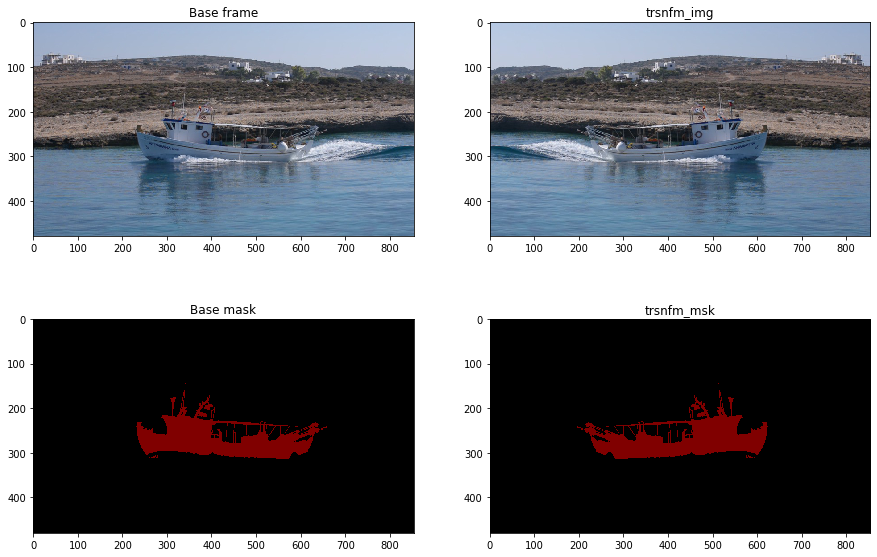

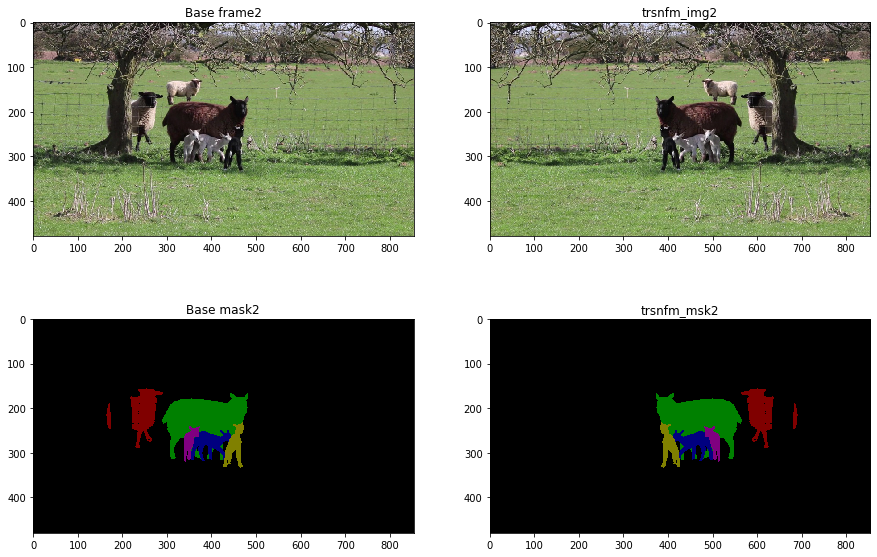

In [283]:

####################### Apply transform
trsnfm_img, trsnfm_msk, trsnfm_img2, trsnfm_msk2 = trnsfm([base_frame,base_mask,base_frame2,base_mask2])
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(base_frame)
plt.title("Base frame")
plt.subplot(2,2,2)
plt.imshow(trsnfm_img)
plt.title("trsnfm_img")
plt.subplot(2,2,3)
plt.imshow(base_mask)
plt.title("Base mask")
plt.subplot(2,2,4)
plt.imshow(trsnfm_msk)
plt.title("trsnfm_msk")
print("new objs_ids:", list(set(np.asarray(trsnfm_msk).reshape(-1))) )

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(base_frame2)
plt.title("Base frame2")
plt.subplot(2,2,2)
plt.imshow(trsnfm_img2)
plt.title("trsnfm_img2")
plt.subplot(2,2,3)
plt.imshow(base_mask2)
plt.title("Base mask2")
plt.subplot(2,2,4)
plt.imshow(trsnfm_msk2)
plt.title("trsnfm_msk2")
print("new objs_ids2:", list(set(np.asarray(trsnfm_msk2).reshape(-1))) )

In [4]:


img_dataset = Custom_DAVIS2017_dataset(root=root, img_shape=img_shape, img_mode=img_mode, rand=True)
img_loader = DataLoader(dataset=img_dataset, num_workers=0, batch_size=2, shuffle=False, pin_memory=True)
print("Image loader ready")

Image loader ready


In [7]:
def forward_feat_extractor(self, template, target, template_msk, target_msk, cap=0):
     #Exact template features
    base_features2 = self.res_forward(template)
    Kernel_3 = F.normalize(f.max_pool2d(self.L3(base_features2[2]), 2))
    Kernel_4 = F.normalize(self.L4(base_features2[3]))
    Kernel_5 = F.normalize(F.interpolate(self.L5(base_features2[4]), scale_factor=2, mode='bilinear',align_corners=True))
    Kernel_tmp = F.normalize(self.L_g(torch.cat([Kernel_3, Kernel_4, Kernel_5], dim=1)))
    Kernel = Kernel_tmp

    # Current frame feature
    base_features1 = self.res_forward(target)
    Feature_3 = F.normalize(f.max_pool2d(self.L3(base_features1[2]), 2))
    Feature_4 = F.normalize(self.L4(base_features1[3]))
    Feature_5 = F.normalize(F.interpolate(self.L5(base_features1[4]), scale_factor=2, mode='bilinear',align_corners=True))
    Feature = F.normalize(self.L_g(torch.cat([Feature_3, Feature_4, Feature_5], dim=1)))


    loss_per_batch = []
    for idx in range(len(Feature)):  # batch
        ker = Kernel_tmp[idx: idx + 1]
        feature = Feature[idx: idx + 1]
        m1 = target_msk[idx: idx + 1]
        m2 = template_msk[idx: idx + 1]

        max_obj = m2.max().int().data.cpu().numpy()
        if max_obj < 2:
            m2[0, 0, 0, 0] = 2
            max_obj = m2.max().int().data.cpu().numpy()
        M2s = self.P2masks(F.relu(m2 - 1), max_obj - 1)
        M2_all = m2.ge(1.5).float()
        M1s = self.P2masks(f.relu(m1 - 1), max_obj - 1)
        M1_all = m1.ge(1.5).float()

        # Correlation
        W0, H0 = ker.size()[-2::]
        W,H = feature.size()[-2::]
        Corr_subs = []
        ker_R = self.to_kernel(ker)
        corr_R = self.correlate(ker_R, feature)

        template_self_corr = self.correlate(ker_R, ker)
        target_self_corr = self.correlate(self.to_kernel(feature), feature)


        for idy in range(max_obj):  # make corrs (backgrounds(=1) and objs)
            m2_rep = f.adaptive_avg_pool2d(M2s[idy], ker.size()[-2::])
            corr_sub = m2_rep.view(m2_rep.size()[0], -1, 1, 1) * corr_R
            Corr_subs.append(corr_sub)

        Outs = []
        loss_per_obj = []
        for idy in range(1, max_obj):  # training:with_bg, testing: w/o BG
            corr = Corr_subs[idy]
            co_size = Corr_subs[idy].size()[2::]

            #### For FG, adjust scores based on how close a pixel is to rest of the FG pixes and far away from BG pixels
            # Self correlation is of size: batch_size x W*H x W x H
            # We want the final score to be a score on each pixel and thus of dimension: batch_size x W*H x 1 x 1
            # Notation meaning: FG_BG: For WxH map with FG pixels, the channels have non zerovalue where 
            #                   channel id corresponds to BG != 0
            m2_rep = f.adaptive_avg_pool2d(M2s[idy], ker.size()[-2::])

            ############# Loss for adjusting feature extractor
            loss_obj_dict = {}
            loss_obj_dict['template_FB_FB_loss'] = 0
            loss_obj_dict['template_FB_BG_loss'] = 0
            loss_obj_dict['target_FB_FB_loss'] = 0
            loss_obj_dict['target_FB_BG_loss'] = 0
            loss_obj_dict['tt_FB_FB_loss'] = 0
            loss_obj_dict['tt_FB_BG_loss'] = 0
            ######### For each FG pixel, find closest 5 pixels in FG and sum them up. That is the -ve loss for FG-FG
            num_pixels= 5
            ############################## Just template frame
            m2_rep_pos = m2_rep.ge(0.5).float()
            m2_rep_neg = m2_rep.le(0).float()
            if (self.fp16):
                m2_rep_pos = m2_rep_pos.half()
                m2_rep_neg = m2_rep_pos.half()
            indices = torch.nonzero(m2_rep_pos.reshape(-1))
            if (len(indices)>0):
                temp_corr = torch.cat([template_self_corr[:,index,:] for index in indices], dim=1)
                FB_FB_loss = (temp_corr*m2_rep_pos).reshape(1,-1,W0*H0)
                FB_FB_loss, _ = FB_FB_loss.sort(descending=True, dim=2)
                FB_FB_loss = FB_FB_loss[:,:,:num_pixels]

                FB_BG_loss = (temp_corr*m2_rep_neg).reshape(1,-1,W0*H0)
                FB_BG_loss, _ = FB_BG_loss.sort(descending=True, dim=2)
                FB_BG_loss = torch.clamp(FB_BG_loss[:,:,:num_pixels]-cap, min=0)

                FB_FB_loss = FB_FB_loss.sum()/(len(indices)*num_pixels)
                FB_BG_loss = FB_BG_loss.sum()/(len(indices)*num_pixels)
                del _
            else:
                FB_FB_loss = 0
                FB_BG_loss = 0

            loss_obj_dict['template_FB_FB_loss'] = -FB_FB_loss
            loss_obj_dict['template_FB_BG_loss'] = FB_BG_loss

            del indices

            ############################## Just target frame
            m1_rep = f.adaptive_avg_pool2d(M1s[idy], ker.size()[-2::])
            m1_rep_pos = m1_rep.ge(0.5).float()
            m1_rep_neg = m1_rep.le(0).float()
            if (self.fp16):
                m1_rep_pos = m1_rep_pos.half()
                m1_rep_neg = m1_rep_pos.half()
            indices = torch.nonzero(m1_rep_pos.reshape(-1))
            if (len(indices)>0):
                temp_corr = torch.cat([target_self_corr[:,index,:] for index in indices], dim=1)
                FB_FB_loss = (temp_corr*m1_rep_pos).reshape(1,-1,W*H)
                FB_FB_loss, _ = FB_FB_loss.sort(descending=True, dim=2)
                FB_FB_loss = FB_FB_loss[:,:,:num_pixels]

                FB_BG_loss = (temp_corr*m1_rep_neg).reshape(1,-1,W*H)
                FB_BG_loss, _ = FB_BG_loss.sort(descending=True, dim=2)
                FB_BG_loss = torch.clamp(FB_BG_loss[:,:,:num_pixels]-cap, min=0)

                FB_FB_loss = FB_FB_loss.sum()/(len(indices)*num_pixels)
                FB_BG_loss = FB_BG_loss.sum()/(len(indices)*num_pixels)
                del _
            else :
                FB_FB_loss = 0
                FB_BG_loss = 0

            loss_obj_dict['target_FB_FB_loss'] = -FB_FB_loss
            loss_obj_dict['target_FB_BG_loss'] = FB_BG_loss
            del indices

            ############################## Between template and target
            ######### Skip this if there are too many objects
            if (max_obj < 10):
                #### Between FG of template and FG of target
                # corr_R is of shape: batch_size x W0*H0 x W x H

                # We want FG of both to be close and FG-BG of both to be far
                FB_FB_loss = (corr_R*m1_rep_pos).reshape(-1,W0*H0,W*H)
                indices1 = torch.nonzero(m1_rep_pos.reshape(-1))
                indices2 = torch.nonzero(m2_rep_pos.reshape(-1))
                corr_R_transpose = corr_R.view(-1, W0*H0, W*H).transpose(1, 2).view(-1, W*H, W0, H0)

                if (len(indices1)>0):
                    FB_FB_loss1, _ = FB_FB_loss.squeeze().transpose(0,1).sort(descending=True, dim=1)
                    FB_FB_loss1 = torch.cat([FB_FB_loss1[index,:num_pixels] for index in indices1], dim=0)
                    FB_FB_loss1 = FB_FB_loss1.sum()/(len(indices1)*num_pixels)

                    FB_BG_loss1 = (corr_R_transpose*m1_rep_neg).reshape(-1,W*H,W0*H0)
                    FB_BG_loss1, _ = FB_BG_loss1.squeeze().sort(descending=True, dim=1)
                    FB_BG_loss1 = torch.clamp(\
                            torch.cat([FB_BG_loss1[index,:num_pixels] for index in indices1], dim=0)-cap, min=0)
                    FB_BG_loss1 = FB_BG_loss1.sum()/(len(indices1)*num_pixels)
                    del _
                else:
                    FB_FB_loss1 = 0
                    FB_BG_loss1 = 0

                if (len(indices2)>0):
                    FB_FB_loss2, _ = FB_FB_loss.squeeze().sort(descending=True, dim=1)
                    FB_FB_loss2 = torch.cat([FB_FB_loss2[index,:num_pixels] for index in indices2], dim=0)
                    FB_FB_loss2 = FB_FB_loss2.sum()/(len(indices2)*num_pixels)

                    FB_BG_loss2 = (corr_R*m2_rep_neg).reshape(-1,W0*H0,W*H)
                    FB_BG_loss2, _ = FB_BG_loss2.squeeze().sort(descending=True, dim=1)
                    FB_BG_loss2 = torch.clamp(\
                            torch.cat([FB_BG_loss2[index,:num_pixels] for index in indices2], dim=0)-cap, min=0)
                    FB_BG_loss2 = FB_BG_loss2.sum()/(len(indices2)*num_pixels)
                    del _
                else:
                    FB_FB_loss2 = 0
                    FB_BG_loss2 = 0

                loss_obj_dict['tt_FB_FB_loss'] = -(FB_FB_loss1 + FB_FB_loss2)/2
                loss_obj_dict['tt_FB_BG_loss'] = (FB_BG_loss1 + FB_BG_loss2)/2
                del indices1,indices2

            loss_per_obj.append(loss_obj_dict)
            ### Loss per object done
        #### Append for loss per image
        loss_per_batch.append(loss_per_obj)
    return loss_per_batch

In [6]:
model.train()

decoder_parameters = []
encoder_parameters = []
for name, param in model.named_parameters():
    if ('base_model' not in name):
        decoder_parameters.append(param)
    else:
        encoder_parameters.append(param)

optimizer_encoder = torch.optim.Adam(encoder_parameters, lr=1e-03)

loss_per_epoch = []

In [8]:
for epoch in range(10):
    start_time = time.perf_counter()
    loss_per_batch = []
    model_train_time = 0

    for iteration, batch in enumerate(img_loader, 1):
        template,template_mask, target,target_mask = batch
        
        template = template.cuda()
        template_mask = template_mask.cuda()
        target = target.cuda()
        target_mask = target_mask.cuda()
        optimizer_encoder.zero_grad()
        
        start_time_model = time.perf_counter()
        lamda1= 0.5
        lamda2 = 0.5
        with torch.enable_grad():
            corr_loss_batch =forward_feat_extractor(self=model, template=template,target=target,\
                                            template_msk=template_mask, target_msk = target_mask,cap=0.4)
            count = 0
            correlation_loss = 0
            for idx in range(len(corr_loss_batch)):  
                template_FB_FB_loss = 0
                template_FB_BG_loss = 0
                target_FB_FB_loss = 0
                target_FB_BG_loss = 0
                tt_FB_FB_loss = 0
                tt_FB_BG_loss = 0
                for idy in range(len(corr_loss_batch[idx])):
                    template_FB_FB_loss += corr_loss_batch[idx][idy]['template_FB_FB_loss']
                    template_FB_BG_loss += corr_loss_batch[idx][idy]['template_FB_BG_loss']
                    target_FB_FB_loss += corr_loss_batch[idx][idy]['target_FB_FB_loss']
                    target_FB_BG_loss += corr_loss_batch[idx][idy]['target_FB_BG_loss']
                    tt_FB_FB_loss += corr_loss_batch[idx][idy]['tt_FB_FB_loss']
                    tt_FB_BG_loss += corr_loss_batch[idx][idy]['tt_FB_BG_loss']
                    count += 1

                correlation_loss += lamda1*(template_FB_FB_loss+target_FB_FB_loss + tt_FB_FB_loss)/3 +\
                                lamda2*(template_FB_BG_loss + target_FB_BG_loss + tt_FB_BG_loss)/3
            correlation_loss  = correlation_loss/count 

        if np.isnan(correlation_loss.item()):
            print("Nan value for loss!, breaking")
            asdsad

        correlation_loss.backward()
        optimizer_encoder.step()
        
        if(type(correlation_loss) is type(0.1)):
            loss_per_batch.append([correlation_loss])
        else:
            loss_per_batch.append([correlation_loss.item()])
        
        del correlation_loss, corr_loss_batch,\
                template, target, template_mask, target_mask
        model_train_time += time.perf_counter() - start_time_model
        
    loss_per_batch = np.array(loss_per_batch)
    loss_per_epoch.append(np.mean(loss_per_batch, axis=0))
    
    end_time = time.perf_counter()
    memory = cuda.memory_allocated(0) /(1024*1024)
    checkpoint_save(opt.workfolder + 'RANet_encoder_retrain', 1, model)
    print("epoch:", epoch, "Time for mini batch:", end_time - start_time,\
          "time spend on model running:",model_train_time,\
          "memory used",memory)

img counter: 1  index: 30
img counter: 1  index: 78
img counter: 1  index: 55
img counter: 1  index: 20
img counter: 1  index: 70
img counter: 1  index: 30
img counter: 1  index: 3
img counter: 1  index: 37
img counter: 1  index: 39
img counter: 1  index: 21
img counter: 1  index: 38
img counter: 1  index: 44
img counter: 1  index: 41
img counter: 1  index: 5
img counter: 1  index: 18
img counter: 1  index: 3
img counter: 1  index: 78
img counter: 1  index: 48
img counter: 1  index: 17
img counter: 1  index: 15
img counter: 1  index: 38
img counter: 1  index: 7
img counter: 1  index: 49
img counter: 1  index: 37
img counter: 1  index: 54
img counter: 1  index: 22
img counter: 1  index: 1
img counter: 1  index: 24
img counter: 1  index: 33
img counter: 1  index: 20
img counter: 1  index: 67
img counter: 1  index: 54
img counter: 1  index: 24
img counter: 1  index: 61
img counter: 1  index: 48
img counter: 1  index: 32
img counter: 1  index: 45
img counter: 1  index: 31
img counter: 1  i

img counter: 5  index: 12
img counter: 5  index: 67
img counter: 5  index: 63
img counter: 5  index: 4
img counter: 5  index: 10
img counter: 5  index: 25
img counter: 5  index: 13
img counter: 5  index: 62
img counter: 5  index: 42
img counter: 5  index: 49
img counter: 5  index: 59
img counter: 5  index: 49
Checkpoint saved to ../models/RANet_encoder_retrain_epoch1.pth
epoch: 4 Time for mini batch: 86.93983189301798 time spend on model running: 51.06534640816972 memory used 836.93505859375
img counter: 6  index: 55
img counter: 6  index: 82
img counter: 6  index: 19
img counter: 6  index: 43
img counter: 6  index: 25
img counter: 6  index: 39
img counter: 6  index: 41
img counter: 6  index: 12
img counter: 6  index: 56
img counter: 6  index: 30
img counter: 6  index: 22
img counter: 6  index: 8
img counter: 6  index: 10
img counter: 6  index: 22
img counter: 6  index: 0
img counter: 6  index: 11
img counter: 6  index: 8
img counter: 6  index: 39
img counter: 6  index: 5
img counter: 

img counter: 10  index: 46
img counter: 10  index: 18
img counter: 10  index: 28
img counter: 10  index: 18
img counter: 10  index: 56
img counter: 10  index: 24
img counter: 10  index: 11
img counter: 10  index: 11
img counter: 10  index: 40
img counter: 10  index: 60
img counter: 10  index: 17
img counter: 10  index: 41
img counter: 10  index: 73
img counter: 10  index: 27
img counter: 10  index: 18
img counter: 10  index: 38
img counter: 10  index: 6
img counter: 10  index: 25
img counter: 10  index: 79
img counter: 10  index: 53
img counter: 10  index: 41
img counter: 10  index: 35
img counter: 10  index: 27
img counter: 10  index: 24
img counter: 10  index: 29
img counter: 10  index: 12
img counter: 10  index: 50
img counter: 10  index: 11
img counter: 10  index: 45
img counter: 10  index: 31
img counter: 10  index: 30
img counter: 10  index: 9
Checkpoint saved to ../models/RANet_encoder_retrain_epoch1.pth
epoch: 9 Time for mini batch: 88.58886481198715 time spend on model running

For a particular foreground pixel, compute and visualize its correlation with target frame

hard images: ( 28:multi people, 14: black dog, 16: weighing machine) <br>
what is image 15 ???

In [65]:
template,template_mask, target,target_mask = img_dataset.__getitem__(index=17)

template = template.cuda().unsqueeze(0)
template_mask = template_mask.cuda().unsqueeze(0)
target = target.cuda().unsqueeze(0)
target_mask = target_mask.cuda().unsqueeze(0)

with torch.no_grad():
    # Target frame feature
    base_features1 = model.res_forward(target)
    Feature_3 = F.normalize(F.max_pool2d(model.L3(base_features1[2]), 2))
    Feature_4 = F.normalize(model.L4(base_features1[3]))
    Feature_5 = F.normalize(F.interpolate(model.L5(base_features1[4]), scale_factor=2, mode='bilinear',\
                                          align_corners=True))
    Feature = F.normalize(model.L_g(torch.cat([Feature_3, Feature_4, Feature_5], dim=1)))

    # Template frame feature
    base_features2 = model.res_forward(template)
    Kernel_3 = F.normalize(F.max_pool2d(model.L3(base_features2[2]), 2))
    Kernel_4 = F.normalize(model.L4(base_features2[3]))
    Kernel_5 = F.normalize(F.interpolate(model.L5(base_features2[4]), scale_factor=2, mode='bilinear',\
                                         align_corners=True))
    Kernel = F.normalize(model.L_g(torch.cat([Kernel_3, Kernel_4, Kernel_5], dim=1)))


    ker = Kernel[:1]
    feature = Feature[:1]
    m2 = template_mask[:1]
    m1 = target_mask[:1]

    max_obj = m2.max().int().data.cpu().numpy()
    if max_obj < 2:
        print("No object in this image!")
    M2s = model.P2masks(F.relu(m2 - 1), max_obj - 1)
    M2_all = m2.ge(1.5).float()
    M1s = model.P2masks(f.relu(m1 - 1), max_obj - 1)
    M1_all = m1.ge(1.5).float()

    W0, H0 = ker.size()[-2::]
    W,H = feature.size()[-2::]
    ker_R = model.to_kernel(Kernel)
    corr_R = model.correlate(ker_R, Feature)

    M2_rep = F.adaptive_avg_pool2d(torch.cat(M2s,dim=0), ker.size()[-2::])
    M1_rep = F.adaptive_avg_pool2d(torch.cat(M1s,dim=0), ker.size()[-2::])

correlation_maps = corr_R.detach().cpu().float().numpy().squeeze()
Masks_template = M2_rep.detach().cpu().float().numpy().squeeze().reshape(len(M2_rep),-1)
Masks_target = M1_rep.detach().cpu().float().numpy().squeeze().reshape(len(M1_rep),-1)
print("memory used:",cuda.memory_allocated(0) /(1024*1024))


img counter: 14  index: 27
memory used: 1037.79248046875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


num masks: 2 i: 1 pixel location: (10, 13)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Correlation for pixel: min: 0.0104, max: 0.9865


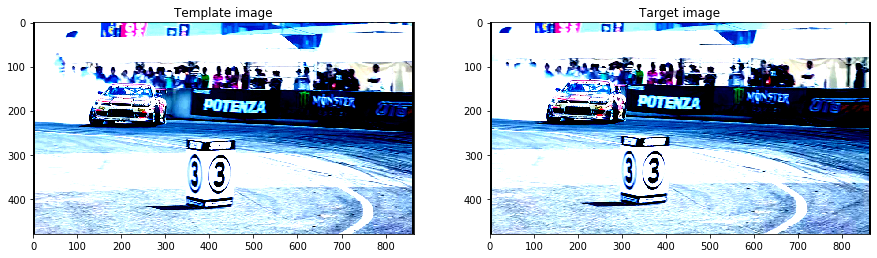

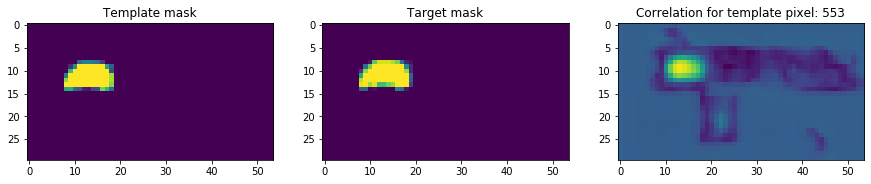

In [66]:

try:
    i
except:
    i = 0
i = (i+1)%len(Masks_template)
if (i==0):
    i = 1

pixel_id = np.random.choice((Masks_template[i]>0.7).nonzero()[0],1)[0]
print("num masks:",len(Masks_template), "i:", i, "pixel location:",(pixel_id//54,pixel_id%54) )

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(template[0].detach().cpu().numpy().reshape(3, -1).T.reshape(480,-1,3))
plt.title("Template image")
plt.subplot(1,2,2)
plt.imshow(target[0].detach().cpu().numpy().reshape(3, -1).T.reshape(480,-1,3))
plt.title("Target image")


plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(Masks_template[i].reshape(W0,H0))
plt.title("Template mask")
plt.subplot(1,3,2)
plt.imshow(Masks_target[i].reshape(W,H))
plt.title("Target mask")
plt.subplot(1,3,3)
plt.imshow(correlation_maps[pixel_id],vmin=0, vmax=1)
# plt.imshow(correlation_maps[pixel_id])
plt.title("Correlation for template pixel: %d"%(pixel_id))
print("Correlation for pixel: min: %.4f, max: %.4f"\
      %(correlation_maps[pixel_id].min(), correlation_maps[pixel_id].max()))

In [63]:
Masks_template[i].reshape(W0,H0)[pixel_id//54,pixel_id%54]

1.0